# **Forecasting Base Station using LSTM Models**



In [9]:
# Import 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random
import time

In [2]:
# Load and Prepare Data
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/chronos_finetune_dataset.csv')

In [5]:
# Create Training and Test Sequences
def create_sequences(df, seq_len):
    X, y = [], []
    for item_id, group in df.groupby('item_id'):
        vals = group.sort_values('timestamp')['target'].values
        for i in range(len(vals) - seq_len):
            X.append(vals[i:i+seq_len])
            y.append(vals[i+seq_len])
    return np.array(X), np.array(y)



def create_test_sequences(df, seq_len):
    X, y, ids = [], [], []
    for item_id, group in df.groupby('item_id'):
        vals = group.sort_values('timestamp')['target'].values
        if len(vals) >= seq_len + 1:
            X.append(vals[-(seq_len+1):-1])
            y.append(vals[-1])
            ids.append(item_id)
    return np.array(X), np.array(y), ids

In [6]:
SEQ_LEN = 5
X_train, y_train = create_sequences(train_df, SEQ_LEN)
X_test, y_test, test_ids = create_test_sequences(test_df, SEQ_LEN)

# Convert Data to Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

In [7]:
# LSTM Model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [11]:
model = LSTMRegressor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
BATCH_SIZE = 32
EPOCHS = 20

start = time.time()

# Section 6: Train LSTM Model
for epoch in range(EPOCHS):
    model.train()
    permutation = torch.randperm(X_train_t.size(0))
    for i in range(0, X_train_t.size(0), BATCH_SIZE):
        indices = permutation[i:i+BATCH_SIZE]
        batch_x, batch_y = X_train_t[indices], y_train_t[indices]
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")
print("Training finished")

elaspe = time.time() - start
print(f"Training time: {elaspe:.2f} seconds")

# Section 7: Make Predictions with LSTM
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).squeeze().numpy()

# Section 8: Calculate RMSE for LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"LSTM RMSE: {rmse_lstm:.4f}")

Epoch 1/20, Loss: 19.0236
Epoch 2/20, Loss: 873.5613
Epoch 2/20, Loss: 873.5613
Epoch 3/20, Loss: 16.7473
Epoch 3/20, Loss: 16.7473
Epoch 4/20, Loss: 726.1377
Epoch 4/20, Loss: 726.1377
Epoch 5/20, Loss: 35.2079
Epoch 5/20, Loss: 35.2079
Epoch 6/20, Loss: 36.8680
Epoch 6/20, Loss: 36.8680
Epoch 7/20, Loss: 23.9071
Epoch 7/20, Loss: 23.9071
Epoch 8/20, Loss: 3.6977
Epoch 8/20, Loss: 3.6977
Epoch 9/20, Loss: 4.8021
Epoch 9/20, Loss: 4.8021
Epoch 10/20, Loss: 44.1074
Epoch 10/20, Loss: 44.1074
Epoch 11/20, Loss: 6.3936
Epoch 11/20, Loss: 6.3936
Epoch 12/20, Loss: 12.3911
Epoch 12/20, Loss: 12.3911
Epoch 13/20, Loss: 99.0791
Epoch 13/20, Loss: 99.0791
Epoch 14/20, Loss: 256.1287
Epoch 14/20, Loss: 256.1287
Epoch 15/20, Loss: 12.1467
Epoch 15/20, Loss: 12.1467
Epoch 16/20, Loss: 13.8548
Epoch 16/20, Loss: 13.8548
Epoch 17/20, Loss: 3.2705
Epoch 17/20, Loss: 3.2705
Epoch 18/20, Loss: 1.4181
Epoch 18/20, Loss: 1.4181
Epoch 19/20, Loss: 30.1204
Epoch 19/20, Loss: 30.1204
Epoch 20/20, Loss: 9.1

Randomly selected sector for sequence plot: T70721A


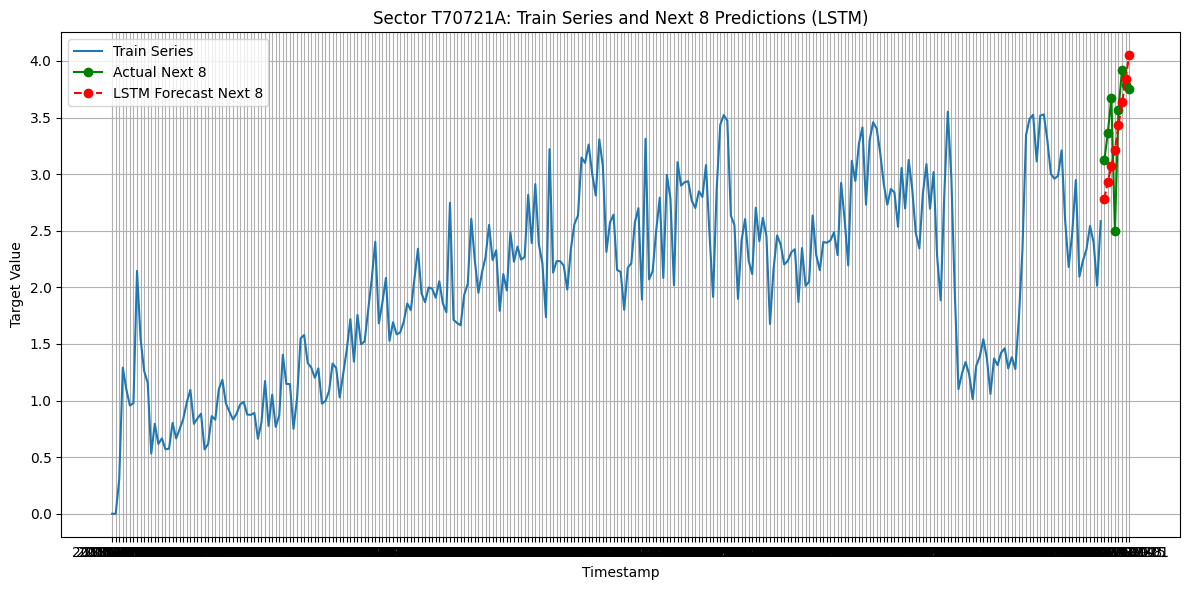

In [16]:
sector_ids_full = test_df['item_id'].unique()
random_sector = random.choice(sector_ids_full)
print(f"Randomly selected sector for sequence plot: {random_sector}")
sector_data = test_df[test_df['item_id'] == random_sector].sort_values('timestamp')
series = sector_data['target'].values
timestamps = sector_data['timestamp'].values
n_forecast = 8
train_series = series[:-n_forecast]
train_timestamps = timestamps[:-n_forecast]
future_actual = series[-n_forecast:]
future_timestamps = timestamps[-n_forecast:]

# LSTM multi-step prediction for next 8 points (recursive)
lstm_multi_preds = []
current_seq = train_series[-SEQ_LEN:].copy()
for i in range(n_forecast):
    input_seq = torch.tensor(current_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    with torch.no_grad():
        pred = model(input_seq).item()
    lstm_multi_preds.append(pred)
    current_seq = np.roll(current_seq, -1)
    current_seq[-1] = pred

# Plot train series and next 8 actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(train_timestamps, train_series, label='Train Series')
plt.plot(future_timestamps, future_actual, 'go-', label='Actual Next 8')
plt.plot(future_timestamps, lstm_multi_preds, 'ro--', label='LSTM Forecast Next 8')
plt.xlabel('Timestamp')
plt.ylabel('Target Value')
plt.title(f'Sector {random_sector}: Train Series and Next 8 Predictions (LSTM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()